# Grid Search for BERT Models

Grid Search with Early Stopping for BERT-like Models <br><br>
**Overview** <br>
This notebook performs hyperparameter tuning using grid search and implements early stopping for fine-tuning BERT-like models (BERT, RoBERTa, Electra) on a downstream classification task. The primary objective is to find the optimal hyperparameters that maximize the model's validation accuracy while preventing overfitting using early stopping.


## Importing libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm

from colorama import Fore, Style
from tqdm.notebook import tqdm
from torch.optim import AdamW
import itertools

from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaConfig, RobertaForSequenceClassification
from transformers import ElectraTokenizer, ElectraConfig, ElectraForSequenceClassification

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score

from transformers import logging
logging.set_verbosity_error()

## Data Preprocessing

In [39]:
# Determine the device to run the model on
# If a GPU with CUDA support is available, use it; otherwise, fallback to the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [40]:
# Load the train, validation and test datasets
train_df = pd.read_csv('../../data/New dataset/BERT/train_tweets_Transformers_new.csv')
validation_df = pd.read_csv('../../data/New dataset/BERT/eval_tweets_Transformers_new.csv')
test_df = pd.read_csv('../../data/New dataset/BERT/test_tweets_Transformers_new.csv')

### Labels encoding

In [41]:
#pd.set_option('future.no_silent_downcasting', True)

# Identify all unique labels in the training dataset
possible_labels = train_df.cyberbullying_type.unique()

# Create a dictionary to map each unique label to a numeric index
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

# Replace the text labels with numeric labels in the training dataframe
# and ensure the column is inferred as the correct data type without copying the data
train_df['label'] = train_df.cyberbullying_type.replace(label_dict).infer_objects(copy=False)

# Do the same replacement for the validation and test dataframes
validation_df['label'] = validation_df.cyberbullying_type.replace(label_dict).infer_objects(copy=False)
test_df['label'] = test_df.cyberbullying_type.replace(label_dict).infer_objects(copy=False)


### Choose the optimal MAX_LEN 

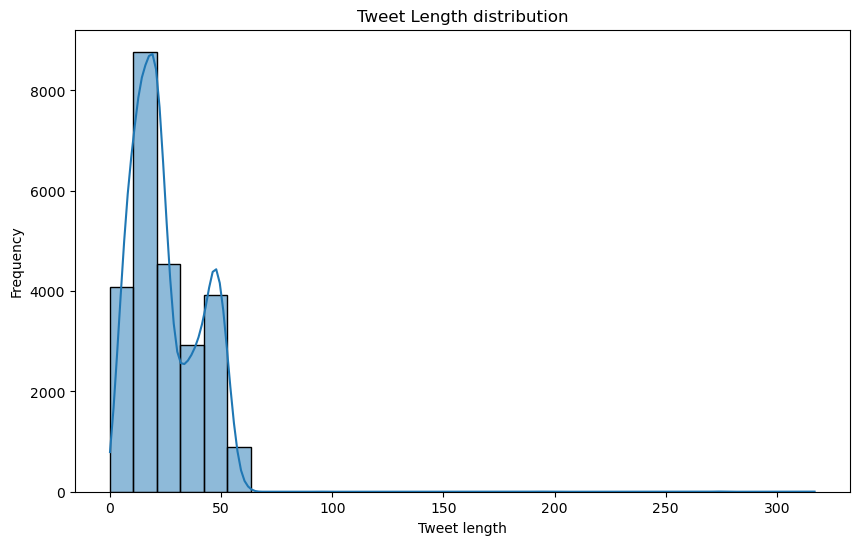

In [42]:
train_df['tweet_length'] = train_df['tweet_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_df['tweet_length'], bins=30, kde=True)
plt.title('Tweet Length distribution')
plt.xlabel('Tweet length')
plt.ylabel('Frequency')
plt.show()

In [43]:
train_df['text_len'] = [len(text.split()) for text in train_df.tweet_text]

max_len = 55
count = (train_df['text_len'] >= max_len).sum() 
total_tweets = len(train_df)
percentage = (count / total_tweets) * 100
print(f"Percentage of tweets longer than {max_len} tokens: {percentage:.2f}%")

Percentage of tweets longer than 55 tokens: 1.77%


In [44]:
max_len = 70
count = (train_df['text_len'] >= max_len).sum() 
total_tweets = len(train_df)
percentage = (count / total_tweets) * 100
print(f"Percentage of tweets longer than {max_len} tokens: {percentage:.2f}%")

Percentage of tweets longer than 70 tokens: 0.04%


In [45]:
max_len = 150
count = (train_df['text_len'] >= max_len).sum() 
total_tweets = len(train_df)
percentage = (count / total_tweets) * 100
print(f"Percentage of tweets longer than {max_len} tokens: {percentage:.2f}%")

Percentage of tweets longer than 150 tokens: 0.03%


The chart shows the distribution of tweet lengths in the dataset. From the distribution, we can see that most tweets have a length of less than 70 characters. This suggests that a MAX_LEN of 70 could be an appropriate choice, as it will cover most tweets without truncating too much data

In [46]:
# Define a fixed maximum length
MAX_LEN = 70

### Data Preparation

In [47]:
# This function encodes the data from a dataframe using a tokenizer corresponding to the specified model checkpoint.
# It returns a dictionary containing the encoded input IDs and attention masks as PyTorch tensors.
def encode_data(df, checkpoint):
    
    # Select the appropriate tokenizer based on the model checkpoint
    if "roberta" in checkpoint:
        tokenizer = RobertaTokenizer.from_pretrained(checkpoint)
    elif "bert" in checkpoint:
        tokenizer = BertTokenizer.from_pretrained(checkpoint)
    elif "electra" in checkpoint:
        tokenizer = ElectraTokenizer.from_pretrained(checkpoint)
    else:
        # Raise an error if the model type is not supported
        raise ValueError("Unsupported model type")
        
    # Tokenize and encode the data
    encoded_data = tokenizer.batch_encode_plus(
        df.tweet_text.values,              # Text data to be encoded
        add_special_tokens = True,         # Add [CLS] and [SEP] special tokens
        return_attention_mask = True,      # Return attention masks
        max_length = MAX_LEN,              
        padding = 'max_length',            # Pad to the maximum length
        truncation = True,                 # Truncate to the maximum length
        return_tensors = 'pt'              # Return PyTorch tensors
    )
    
    return encoded_data

In [48]:
# Encode the data and create TensorDataset objects for the training and validation datasets
def get_tensordatasets(checkpoint):

    # Encode data
    encoded_data_train = encode_data(train_df, checkpoint)
    encoded_data_val = encode_data(validation_df, checkpoint)

    # Extract input_ids_train and attention_masks_train; convert labels into tensors
    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(train_df.label.values)

    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(validation_df.label.values)

    # Create datasets based on tensors, combining the input IDs, attention masks, and labels for the training set into a TensorDataset.
    # This allows the data to be easily accessed and used by PyTorch's DataLoader.
    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

    return dataset_train, dataset_val

In [49]:
# Create DataLoader objects for training and validation datasets
def get_dataloaders(dataset_train, dataset_val, batch_size):
    
    # Create DataLoader for the training set with random sampling
    dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

    # Create DataLoader for the validation set with sequential sampling
    dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

    return dataloader_train, dataloader_validation

## Define utility functions for the grid search

In [50]:
class EarlyStopping(object):
    """
    Implements early stopping to terminate training when the validation loss stops improving.
    
    Parameters:
    - min_delta: minimum change in the monitored metric to qualify as an improvement
    - patience: number of epochs to wait for an improvement before stopping.
    - percentage: whether to interpret min_delta as a percentage or an absolute number.
    """

    def __init__(self, min_delta=0, patience=1, percentage=True):
        self.min_delta = min_delta
        self.patience = patience
        self.best = None            # Best metric observed so far
        self.num_bad_epochs = 0     # Counter for epochs with no improvement
        self.is_better = None       # Function to determine if the current metric is better than the best observed
        self._init_is_better(min_delta, percentage)     # Initialize the comparison function

    def step(self, metrics):
        if self.best is None:
            self.best = metrics     # Initialize the best metric with the first value
            return False            # Continue training

        if not isinstance(metrics, torch.Tensor):
            metrics = torch.tensor(metrics)
            
        if torch.isnan(metrics):
            print("Error: TORCH IS NAN")
            return True

        if self.is_better(metrics, self.best):
            # If an improvement is registered, reset the counter and update the best metric
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            # If no improvement, increase the counter
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            # Stop training if the number of bad epochs exceeds patience
            print(Fore.BLUE + Style.BRIGHT + 'terminating because of early stopping!'+ Style.RESET_ALL)
            return True
            
        return False    # Continue training

    def _init_is_better(self, min_delta, percentage):
        if not percentage:
            # Use absolute change for comparison
            self.is_better = lambda a, best: a < best - min_delta
        else:
            # Use percentage change for comparison
            self.is_better = lambda a, best: a < best - (best * min_delta / 100)

In [51]:
# Train the model for one epoch.
# It returns avg_train_loss_one_epoch: the average training loss for the epoch
def train_one_epoch(model, train_dataloader, optimizer, device=device):
    model.train()           # Set the model to training mode

    total_train_loss = 0    # Initialize the total training loss
    train_progress = tqdm(train_dataloader, desc="Training", leave=False)    # Progress bar for training
    
    for batch in train_progress:
        # Unpack the batch
        input_ids, attention_masks, labels = batch
        
        # Move tensors to the specified device
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        
        # Clear previously calculated gradients
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(input_ids, token_type_ids=None, 
                        attention_mask=attention_masks, labels=labels)

        # Get the loss from the model outputs
        loss = outputs.loss

        # Backward pass: compute gradient
        loss.backward()

        # Clip the gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        train_progress.set_postfix(loss=loss.item())
        
        total_train_loss += loss.item()
    
    avg_train_loss_one_epoch = total_train_loss / len(train_dataloader)

    return avg_train_loss_one_epoch
    
# Evaluate the model for one epoch
# It returns 
# - avg_val_acc: the average validation accuracy for the epoch
# - avg_val_loss: the average validation loss for the epoch
def eval_one_epoch(model, eval_dataloader, device=device):
    model.eval()    # Set the model to evaluation mode

    val_accuracy, total_eval_loss = 0, 0    # Initialize accuracy and loss
    val_progress = tqdm(eval_dataloader, desc="Validation", leave=False)    # Progress bar for evaluation
    
    for batch in val_progress:
        # Unpack the batch
        input_ids, attention_masks, labels = batch
        
        # Move tensors to the specified device
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, token_type_ids=None, 
                            attention_mask=attention_masks, labels=labels)
        
        logits = outputs.logits
        
        predictions = torch.argmax(logits, dim=-1)
        val_accuracy += accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        
        loss = outputs.loss
        total_eval_loss += loss.item()

    avg_val_loss = total_eval_loss / len(eval_dataloader)
    avg_val_acc = val_accuracy / len(eval_dataloader)
    #print(f"Validation loss: {avg_val_loss}")    
    #print(f"Validation Accuracy: {avg_val_acc:.4f}")

    return avg_val_acc, avg_val_loss

## Run the grid search

In [52]:
param_grid = {
    'learning_rate': [3e-4, 1e-4, 5e-5, 3e-5],
    'batch_size': [32, 64],
    'hidden_dropout_prob': [0.0, 0.3, 0.5],
    'attention_probs_dropout_prob': [0.0, 0.3, 0.5]
}

In [53]:
# Perform a grid search to find the best hyperparameters for the model
# This function will train and evaluate the model using different combinations of hyperparameters
# It returns 
# - best_params: The best hyperparameters found during the grid search
# - best_score: The best score (validation accuracy) achieved with the best hyperparameters
    
def grid_search(checkpoint, param_grid=param_grid, device=device):
    best_params = None
    best_score = 0
    max_epochs = 10

    # Obtain TensorDataset for train set and validation set
    dataset_train, dataset_val = get_tensordatasets(checkpoint)

    # Total number of hyperparameter combinations to search
    total_combinations = len(param_grid['learning_rate']) * len(param_grid['batch_size']) * len(param_grid['hidden_dropout_prob']) * len(param_grid['attention_probs_dropout_prob']) * max_epochs

    # Initialize progress bar for the grid search
    with tqdm(total=total_combinations, desc="Grid Search Progress") as pbar:

        # Iterate over all combinations of hyperparameters
        for lr, bs, hidden_dropout, attention_dropout in itertools.product(param_grid['learning_rate'], param_grid['batch_size'], param_grid['hidden_dropout_prob'], param_grid['attention_probs_dropout_prob']):
            
            # Model initialization
            if "roberta" in checkpoint:
                config = RobertaConfig.from_pretrained(checkpoint, 
                                                hidden_dropout_prob=hidden_dropout, 
                                                attention_probs_dropout_prob=attention_dropout,
                                                num_labels=len(label_dict))
                model = RobertaForSequenceClassification.from_pretrained(checkpoint, config=config)
            
            elif "bert" in checkpoint:
                config = BertConfig.from_pretrained(checkpoint, 
                                                hidden_dropout_prob=hidden_dropout, 
                                                attention_probs_dropout_prob=attention_dropout,
                                                num_labels=len(label_dict))
                model = BertForSequenceClassification.from_pretrained(checkpoint, config=config)
            
            elif "electra" in checkpoint:
                config = ElectraConfig.from_pretrained(checkpoint, 
                                                hidden_dropout_prob=hidden_dropout, 
                                                attention_probs_dropout_prob=attention_dropout,
                                                num_labels=len(label_dict))
                model = ElectraForSequenceClassification.from_pretrained(checkpoint, config=config)
            
            else:
                raise ValueError("Unsupported model type")
        
            # Move model to the specified device
            model.to(device)
            
            print(f"\nGrid Search {checkpoint}...")
            
            # Initialization steps
            optimizer = AdamW(model.parameters(), lr=lr)
            train_loss, validation_loss, validation_acc = [], [], []
            early_stopping = EarlyStopping(min_delta=20, patience=2)
            total_acc_score = 0
            
            # Obtain DataLoader objects for the training and validation datasets
            train_dataloader, val_dataloader = get_dataloaders(dataset_train, dataset_val, bs)

            for i in range(max_epochs):
                print(Fore.GREEN + Style.BRIGHT + f"Epoch {i+1} | LR {lr} | BS {bs} | Hidden Dropout {hidden_dropout} | Attention Dropout {attention_dropout}" + Style.RESET_ALL)
                
                # Train the model for one epoch
                avg_train_loss_one_epoch = train_one_epoch(model, train_dataloader, optimizer)
                train_loss.append(avg_train_loss_one_epoch)
            
                # Validation 
                epoch_acc_score, avg_val_loss_one_epoch = eval_one_epoch(model, val_dataloader)
                validation_loss.append(avg_val_loss_one_epoch)
                validation_acc.append(epoch_acc_score)
                
                total_acc_score += epoch_acc_score
             
                # Check for early stopping
                if early_stopping.step(avg_val_loss_one_epoch):
                    print("Early stopping at epoch:", i+1)
                    break
                             
                average_val_accuracy = total_acc_score / (i+1)
                #print(f"Average val accuracy ({i+1} epochs): {average_val_accuracy:.4f}")

                max_val_acc_one_epoch = max(validation_acc)
                print(f"Max val accuracy ({i+1} epochs): {max_val_acc_one_epoch:.4f}")
                
                score = max_val_acc_one_epoch

                if score > best_score:
                    best_score = score
                    best_params = {'learning_rate': lr, 'batch_size': bs, 'hidden_dropout_prob': hidden_dropout, 'attention_probs_dropout_prob': attention_dropout, 'num_train_epochs': i+1}

                pbar.update(1) # Update progress bar
    
    return best_params, best_score

# Run the grid search

In [54]:
best_params_1, best_score_1 = grid_search("bert-base-uncased")
print(f'The best parameters found are: {best_params_1} with a score of: {best_score_1}\n')

Grid Search Progress:   0%|          | 0/720 [00:00<?, ?it/s]


Grid Search bert-base-uncased...
Epoch 1 | LR 0.0003 | BS 32 | Hidden Dropout 0.0 | Attention Dropout 0.0


Training:   0%|          | 0/787 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
best_params_2, best_score_2 = grid_search("bert-large-uncased-whole-word-masking")
print(f'The best parameters found are: {best_params_2} with a score of: {best_score_2}\n')

In [ ]:
best_params_3, best_score_3 = grid_search("roberta-base")
print(f'The best parameters found are: {best_params_3} with a score of: {best_score_3}\n')

In [ ]:
best_params_4, best_score_4 = grid_search("google/electra-base-discriminator")
print(f'The best parameters found are: {best_params_4} with a score of: {best_score_4}\n')